In [1]:
# Loading dataset
import torchvision
import torch



In [2]:
print(torchvision.__version__)
print(torch.__version__)

0.13.0+cu102
1.12.0+cu102


In [ ]:
#%pip install torch==1.12.0

In [ ]:
#%pip install torchvision==0.13.0

# Loading dataset

In [3]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-g52yio7l
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-g52yio7l
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 740dab561ccf54a9ae4bb5bda3b8b18df3790025
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 42.0 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0.dev0-py3-none-any.whl size=97989 sha256=a11a4e5598dd8007dc92496f42d1515b6bd7f20a62243f754714e13141

In [4]:
#!pip install "opencv-python-headless<4.3"

In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torchvision

In [6]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module


from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [7]:
#Traing dataset in gdrive.
#from google.colab import drive
#drive.mount('/content/gdrive')

In [8]:
import pathlib
import glob


x_train_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/train"))
y_train_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/train"))
y_train_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/train"))

x_valid_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/val"))
y_valid_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/val"))
y_valid_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/val"))

'''
x_train_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/train")
y_train_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/train")
y_train_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/train")

x_valid_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/val")
y_valid_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/val")
y_valid_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/val")

x_test_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/test")
y_test_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/test")
y_test_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/test")
'''

'\nx_train_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/train")\ny_train_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/train")\ny_train_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/train")\n\nx_valid_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/val")\ny_valid_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/val")\ny_valid_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/val")\n\nx_test_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/test")\ny_test_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/test")\ny_test_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/test")\n'

In [9]:
SIZE_X = 224 
SIZE_Y = 224

# Dataloader and utility functions 

In [10]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

In [11]:
from torch.utils.data import Dataset


# classes for data loading and preprocessing
class CityDataset(Dataset):
    
    CLASSES =   ['road','sidewalk','building','wall','fence','pole',
                'traffic light','traffic sign','vegetation','terrain','sky',
                'person','rider','car','truck','bus',
                'train','motorcycle','bicycle','unlabeled']

    def __init__(
            self, 
            images_dir, 
            masks_dir,
            dep_dir, 
            classes=None, 
            transform=None, 
            preprocessing=None,
    ):
        
        lis_x = sorted(os.listdir(images_dir)) 
        lis_y_seg = sorted(os.listdir(masks_dir))
        lis_y_dep = sorted(os.listdir(dep_dir))

        self.images_fps = [image for link in lis_x for image in sorted(glob.glob(os.path.join(images_dir,link)+'/*.png'))]
        self.masks_fps = [image for link in lis_y_seg for image in sorted(glob.glob(os.path.join(masks_dir,link)+'/*.png'))]
        self.depth_fps = [image for link in lis_y_dep for image in sorted(glob.glob(os.path.join(dep_dir,link)+'/*.png'))]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.transform = transform
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        sample = {}
        # read data.
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, (SIZE_Y, SIZE_X))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample['image'] = image

        #Read Maskdata.
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))

        # extract certain classes from mask (e.g. cars)
        masks = []
        for v in self.class_values:
            if v == 19:
                masks.append((mask == 255))
            else :
                masks.append((mask == v))

        mask = np.stack(masks, axis=-1).astype('float')

        sample['seg'] = mask

        #Read Depth-data.
        dep = cv2.imread(self.depth_fps[i])
        dep = cv2.resize(dep, (SIZE_Y, SIZE_X))

        sample['dep'] = dep

        # apply augmentations
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['seg']

        # apply preprocessing
        if self.preprocessing:
            sample['image'] = self.preprocessing(sample['image'])
            #image, mask = sample['image'], sample['mask']          
 
        t= torchvision.transforms.ToTensor()
        
        sample['image'] = t(sample['image']).to(torch.float)
        sample['seg'] = t(sample['seg']).to(torch.float)
        sample['dep'] = t(sample['dep'][:,:,0]).to(torch.float)
        #norm  = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #sample['image'] = norm(sample['image'])
 
   

        return sample
        
    def __len__(self):
        return len(self.images_fps)


In [12]:
# Lets look at data we have
dataset = CityDataset(x_train_dir, y_train_seg_dir,y_train_dep_dir, classes=['car', 'person'])

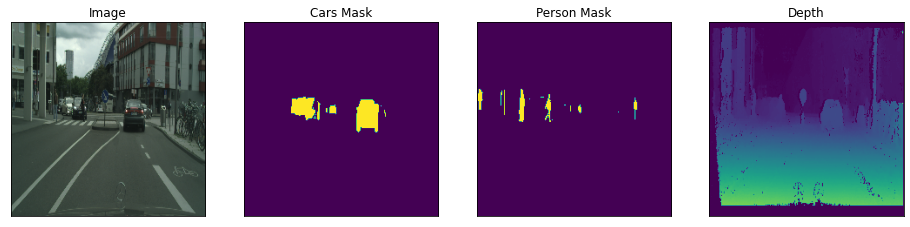

In [13]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Person_mask=mask.data.numpy().transpose(1,2,0)[..., 1],
    depth = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0)
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [14]:
import functools

def preprocess_input(x, mean=None, std=None, input_range=None, **kwargs):

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

def get_preprocessing_fn():
    formatted_settings = {}
    formatted_settings["input_range"] = [0, 1]
    formatted_settings["mean"] = [0.485, 0.456, 0.406]
    formatted_settings["std"] = [0.229, 0.224, 0.225]
    return functools.partial(preprocess_input, **formatted_settings)

In [15]:
# Lets look at augmented data we have
#norm  = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = CityDataset(x_train_dir, y_train_seg_dir,y_train_dep_dir, classes=['car', 'person'],transform=None,preprocessing=get_preprocessing_fn())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


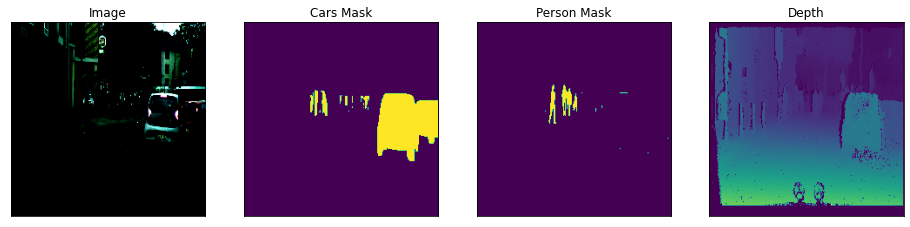

In [16]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Person_mask=mask.data.numpy().transpose(1,2,0)[..., 1],
    depth = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0)
)

# Model parameters defination.

In [17]:
#Database.
Train_Batch_size = 8
Val_Batch_size = 8
nworkers = 4

#Optimiser and Scheduler.
epochs = 100
#Lr = 0.0001
Lr = 0.0001
#Model Parameters

CLASSES = ['road','sidewalk','building','wall','fence','pole',
                'traffic light','traffic sign','vegetation','terrain','sky',
                'person','rider','car','truck','bus',
                'train','motorcycle','bicycle','unlabeled']

#CLASSES = ['car', 'person']
Num_channels = 3

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation+ Background
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#task-type .
task_type = 'multi'  # Select 'single' or 'multi'

In [18]:
%pip install easydict

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6360 sha256=c48e38dfb02d5e2bea06982d0897914ff0c639fd7b2c4427339e9a3d00cd2e4c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d3/e0/e9/305e348717e399665119bd012510d51ff4f22d709ff60c3096
Successfully built easydict
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
from easydict import EasyDict as edict

FLAGVALS = cv2.INTER_NEAREST 
INFER_FLAGVALS = cv2.INTER_NEAREST

p =edict()
p['NAMES'] = ['seg','dep']
p['NUM_OUTPUT'] = {'seg':n_classes,'dep':1}
p['FLAGVALS'] = {'seg':FLAGVALS,'dep':FLAGVALS}
p['INFER_FLAGVALS'] = {'seg':INFER_FLAGVALS,'dep':INFER_FLAGVALS}

In [20]:
import warnings

def get_output(output,task):
    output = output.permute(0, 2, 3, 1)

    if task == 'seg':
      _, output = torch.max(output, dim=3)
    elif task == 'dep':
        pass
    else:
        raise ValueError("Invalid Selection")
    
    return output

#General Model evaluator
@torch.no_grad()
def eval_model_results(data_loader,model,n_classes=20, has_bg=False):
    n_classes = n_classes + int(has_bg)

    # Iterate
    tp = [0] * n_classes
    fp = [0] * n_classes
    fn = [0] * n_classes

    total_rmses = 0.0
    total_log_rmses = 0.0
    n_valid = 0.0
    output = dict()

    model.eval()
    for ii, sample in enumerate(data_loader):
        if torch.cuda.is_available():
            inputimg = sample['image'].cuda(non_blocking=True) 
            gt_masks = sample['seg'].cuda(non_blocking=True)
            gt_deps = sample['dep'].cuda(non_blocking=True)
        else:
            inputimg = sample['image']
            gt_masks = sample['seg']
            gt_deps = sample['dep']            

        output['seg'],output['dep']  = model(inputimg)
        
        for i,task in enumerate(p.NAMES):
            output[task] = get_output(output[task],task)
        
        gt_masks = get_output(gt_masks,'seg')
        gt_deps = get_output(gt_deps,'dep')

        #print(gt_masks.shape,output.shape)

        for jj in range(int(inputimg.size()[0])):
            #Segmentation evaluation.
            pred_mask = output['seg'][jj].cpu().data.numpy().squeeze()
            gt_mask = gt_masks[jj].cpu().data.numpy().squeeze()
              ##Semantic Segmentaion.               
              # resize - cv2.resize(output_task[jj], dsize=(meta['im_size'][1][jj], meta['im_size'][0][jj]), interpolation=p.TASKS.INFER_FLAGVALS[task])
      
            valid = (gt_mask != 255)

            if pred_mask.shape != gt_mask.shape:
                warnings.warn('Prediction and ground truth have different size. Resizing Prediction..')
                pred_mask = cv2.resize(pred_mask, gt_mask.shape[::-1], interpolation=cv2.INTER_NEAREST)

            # TP, FP, and FN evaluation
            for i_part in range(0, n_classes):
                tmp_gt = (gt_mask == i_part)
                tmp_pred = (pred_mask == i_part)
                tp[i_part] += np.sum(tmp_gt & tmp_pred & valid)
                fp[i_part] += np.sum(~tmp_gt & tmp_pred & valid)
                fn[i_part] += np.sum(tmp_gt & ~tmp_pred & valid)

            #Depth estimation.
            pred_dep = output['dep'][jj].cpu().data.numpy().squeeze()
            gt_dep = gt_deps[jj].cpu().data.numpy().squeeze()

            if pred_dep.shape != gt_dep.shape:
                warnings.warn('Prediction and ground truth have different size. Resizing Prediction..')
                pred_dep = cv2.resize(pred_dep, gt_dep.shape[::-1], interpolation=cv2.INTER_LINEAR)

            valid_mask = (gt_dep != 0)
            n_valid += np.sum(valid_mask)

            gt_dep[gt_dep == 0] = 1e-9 # Avoid overflow/underflow
            pred_dep[pred_dep <= 0] = 1e-9

            log_rmse_tmp = (np.log(gt_dep[valid_mask]) - np.log(pred_dep[valid_mask])) ** 2
            total_log_rmses += np.sum(log_rmse_tmp)

            rmse_tmp = (gt_dep[valid_mask] - pred_dep[valid_mask]) ** 2
            total_rmses += np.sum(rmse_tmp)


    jac = [0] * n_classes
    for i_part in range(0, n_classes):
        jac[i_part] = float(tp[i_part]) / max(float(tp[i_part] + fp[i_part] + fn[i_part]), 1e-8)
  
    # Write results
    eval_result = dict()
    eval_result['jaccards_all_categs'] = jac
    eval_result['mIoU'] = np.mean(jac)
    eval_result['rmse'] = np.sqrt(total_rmses / n_valid)
    eval_result['log_rmse'] = np.sqrt(total_log_rmses / n_valid)

    return eval_result


In [21]:
#Directory for result storage.
def mkdir_if_missing(directory):
    if not os.path.exists(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

root = os.path.join(os.getcwd(),'results')

output_dir = os.path.join(root, 'CityScapes', 'UNet', 'MTL_Baseline')
save_dir = os.path.join(output_dir, 'results')
checkpoint = os.path.join(output_dir, 'checkpoint.pth.tar')
best_model = os.path.join(output_dir, 'best_model.pth.tar')

mkdir_if_missing(output_dir)
mkdir_if_missing(save_dir)

#Building the model.

In [22]:
#Importing Denset backbone network
from torchvision.models import DenseNet
#from torchvision.models.densenet import _Transition, _load_state_dict,DenseNet121_Weights
from torchvision.models.densenet import _Transition, _load_state_dict,DenseNet121_Weights
from collections import OrderedDict

In [23]:
class _DenseUNetEncoder(DenseNet):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, downsample=False):
        super(_DenseUNetEncoder, self).__init__(growth_rate, block_config, num_init_features, bn_size, drop_rate)

        # remove last norm, classifier
        features = OrderedDict(list(self.features.named_children())[:-1])
        delattr(self, 'classifier')
        if not downsample:
            features['conv0'].stride = 1
            del features['pool0']
        self.features = nn.Sequential(features)
          

    def forward(self, x):
        return self.features(x)

In [24]:
class _DenseUNetDecoder(DenseNet):
    def __init__(self,tasks, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, downsample=False):
        super(_DenseUNetDecoder, self).__init__(growth_rate, block_config, num_init_features, bn_size, drop_rate)
        
        self.upsample = downsample
        self.tasks = tasks
        
        features = dict()
        self.features_1 = torch.nn.ModuleDict()
        
        for task in self.tasks:

            features[task] = list(self.features.named_children())[4:-2]
            #delattr(self, 'classifier')

            num_features = num_init_features
            num_features_list = []
            for i, num_layers in enumerate(block_config):
                num_input_features = num_features + num_layers * growth_rate
                num_output_features = num_features // 2
                num_features_list.append((num_input_features, num_output_features))
                num_features = num_input_features // 2
        
            for i in range(len(features[task])):
                name, module = features[task][i]
                if isinstance(module, _Transition):
                    num_input_features, num_output_features = num_features_list.pop(1)
                    features[task][i] = (name, _TransitionUp(num_input_features, num_output_features))

            features[task].reverse()
        
            self.features_1[task] = nn.Sequential(OrderedDict(features[task]))
        
            num_input_features, _ = num_features_list.pop(0)
        
            if downsample:
                self.features_1[task].add_module('upsample0', nn.Upsample(scale_factor=4, mode='bilinear'))
            self.features_1[task].add_module('norm0', nn.BatchNorm2d(num_input_features))
            self.features_1[task].add_module('relu0', nn.ReLU(inplace=True))
            self.features_1[task].add_module('conv0', nn.Conv2d(num_input_features, num_init_features, kernel_size=1, stride=1, bias=False))
            self.features_1[task].add_module('norm1', nn.BatchNorm2d(num_init_features))
        #self.classifier = nn.Conv2d(num_init_features, n_classes, kernel_size=1, stride=1, bias=True)
        
    def forward(self, x):
        return self.features[self.tasks[0]](x),self.features[self.tasks[1]](x)
        #x = self.features(x)
        #return self.classifier(x)
        

In [25]:
class _Concatenate(nn.Module):
    def __init__(self):
        super(_Concatenate, self).__init__()
        
    def forward(self, x,y):
        return torch.cat([x, y], 1)

class _TransitionUp(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_TransitionUp, self).__init__()
        
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, num_output_features * 2,
                                              kernel_size=1, stride=1, bias=False))
        
        self.add_module('upsample', nn.Upsample(scale_factor=2, mode='bilinear'))
        self.add_module('cat', _Concatenate())
        self.add_module('norm2', nn.BatchNorm2d(num_output_features * 4))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(num_output_features * 4, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        
    def forward(self, x,y):
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.cat(x,y)
        x = self.norm2(x)
        x = self.relu2(x)            
            
        return self.conv2(x) 

In [26]:
class MultiTaskModel(nn.Module):
    """ Multi-task baseline model with shared encoder + task-specific decoders """
    def __init__(self,tasks: list,output: dict,pretrained_encoder_uri=None, progress=None):
        super(MultiTaskModel, self).__init__()
        self.tasks = tasks
        
        self.encoder = _DenseUNetEncoder(downsample=True)

        self.encoder._load_state_dict = self.encoder.load_state_dict
        self.encoder.load_state_dict = lambda state_dict : self.encoder._load_state_dict(state_dict, strict=False)
        if pretrained_encoder_uri:
            _load_state_dict(self.encoder, pretrained_encoder_uri, progress)
        self.encoder.load_state_dict = lambda state_dict : self.encoder._load_state_dict(state_dict, strict=True)
        
        self.decoder = _DenseUNetDecoder(self.tasks,downsample =True)

        self.out = torch.nn.ModuleDict()
        for task in self.tasks:
            self.out[task] = nn.Conv2d(64, output[task], kernel_size=1, stride=1)
            
    def forward(self, x):
        #return {task: self.decoders[task](self.encoder(x)) for task in self.tasks}
        pre_pools = dict()
        #encoder pass
        x = self.encoder.features.conv0(x)
        x = self.encoder.features.norm0(x)
        x = self.encoder.features.relu0(x)
        x = self.encoder.features.pool0(x)
                  
        x = self.encoder.features.denseblock1(x)
        x = self.encoder.features.transition1.norm(x)
        x = self.encoder.features.transition1.relu(x)
        x = self.encoder.features.transition1.conv(x)
        pre_pools[f"layer_0"] = x
        x = self.encoder.features.transition1.pool(x)
        
        x = self.encoder.features.denseblock2(x)
        x = self.encoder.features.transition2.norm(x)
        x = self.encoder.features.transition2.relu(x)
        x = self.encoder.features.transition2.conv(x)
        pre_pools[f"layer_1"] = x
        x = self.encoder.features.transition2.pool(x)
        
        x = self.encoder.features.denseblock3(x)
        x = self.encoder.features.transition3.norm(x)
        x = self.encoder.features.transition3.relu(x)
        x = self.encoder.features.transition3.conv(x)
        pre_pools[f"layer_2"] = x
        x = self.encoder.features.transition3.pool(x)
        
        #self.encoder.features.denseblock4(x)
        
        #decoder pass
        #decoder-1

       
        y = self.decoder.features_1['seg'].transition3(self.encoder.features.denseblock4(x),pre_pools[f"layer_2"])
        y = self.decoder.features_1['seg'].denseblock3(y)
        
        y = self.decoder.features_1['seg'].transition2(y,pre_pools[f"layer_1"])
        y = self.decoder.features_1['seg'].denseblock2(y)
        
        y = self.decoder.features_1['seg'].transition1(y,pre_pools[f"layer_0"])
        y = self.decoder.features_1['seg'].denseblock1(y)
        
        y = self.decoder.features_1['seg'].upsample0(y)
        y = self.decoder.features_1['seg'].norm0(y)
        y = self.decoder.features_1['seg'].relu0(y)
        y = self.decoder.features_1['seg'].conv0(y)
        y = self.decoder.features_1['seg'].norm1(y)
        
        #decoder-2
        
        x = self.decoder.features_1['dep'].transition3(self.encoder.features.denseblock4(x),pre_pools[f"layer_2"])
        x = self.decoder.features_1['dep'].denseblock3(x)
        
        x = self.decoder.features_1['dep'].transition2(x,pre_pools[f"layer_1"])
        x = self.decoder.features_1['dep'].denseblock2(x)
        
        x = self.decoder.features_1['dep'].transition1(x,pre_pools[f"layer_0"])
        x = self.decoder.features_1['dep'].denseblock1(x)
        
        x = self.decoder.features_1['dep'].upsample0(x)
        x = self.decoder.features_1['dep'].norm0(x)
        x = self.decoder.features_1['dep'].relu0(x)
        x = self.decoder.features_1['dep'].conv0(x)
        x = self.decoder.features_1['dep'].norm1(x)
        
        del pre_pools
        
        return self.out[self.tasks[0]](y),self.out[self.tasks[1]](x)


In [27]:
#heads = torch.nn.ModuleDict({task: _DenseUNetDecoder(skip_connections[task], n_classes=p.NUM_OUTPUT[task],downsample =True) for task in p.NAMES})
#model = MultiTaskModel(p.NAMES,p.NUM_OUTPUT,heads,skip_connections, pretrained_encoder_uri=DenseNet121_Weights.IMAGENET1K_V1)

#task_out = {task: p.NUM_OUTPUT[task] for task in p.NAMES}
model = MultiTaskModel(p.NAMES,p.NUM_OUTPUT,pretrained_encoder_uri=DenseNet121_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [28]:
if torch.cuda.is_available():
    model.cuda()
#model

# Traning the model.

In [29]:
#from torchsummary import summary

#print(summary(model,(Num_channels,SIZE_X,SIZE_Y)))

In [30]:
import segmentation_models_pytorch as smp

In [31]:
#define the crireia

#Cross-entropyloss
class SoftMaxwithLoss(Module):
    """
    This function returns cross entropy loss for semantic segmentation
    """

    def __init__(self):
        super(SoftMaxwithLoss, self).__init__()
        #self.softmax = nn.LogSoftmax(dim=1)
        #self.criterion = nn.NLLLoss(ignore_index=255)
        #self.criterion = smp.losses.DiceLoss(mode='multiclass',classes = [x for x in range(n_classes)])
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, out, label):
        assert not label.requires_grad
        # out shape  batch_size x channels x h x w
        # label shape batch_size x 1 x h x w
        #label = label[:, 0, :, :].long()
        loss = self.criterion(out, label)

        return loss

#Depth-loss
class DepthLoss(nn.Module):
    """
    Loss for depth prediction. By default L1 loss is used.  
    """
    def __init__(self, loss='l1'):
        super(DepthLoss, self).__init__()
        if loss == 'l1':
            self.loss = nn.L1Loss()

        else:
            raise NotImplementedError('Loss {} currently not supported in DepthLoss'.format(loss))

    def forward(self, out, label):
        mask = (label != 255)
        return self.loss(torch.masked_select(out, mask), torch.masked_select(label, mask))

def get_loss(task=None):
    """ Return loss function for a specific task """
    if task == 'seg' :
        criterion = SoftMaxwithLoss()
    elif task == 'dep':
        criterion = DepthLoss()
    else:
        raise NotImplementedError('Undefined Loss: Choose a task among '
                                  'edge, semseg, human_parts, sal, depth, or normals')

    return criterion

class MultiTaskLoss(nn.Module):
    def __init__(self, tasks: list, loss_ft: nn.ModuleDict, loss_weights: dict):
        super(MultiTaskLoss, self).__init__()
        assert(set(tasks) == set(loss_ft.keys()))
        assert(set(tasks) == set(loss_weights.keys()))
        self.tasks = tasks
        self.loss_ft = loss_ft
        self.loss_weights = loss_weights
        #self.loss_scale = nn.Parameter(torch.tensor([-0.5]*len(tasks))).cuda()
    
    def forward(self, pred, gt):
        out = {task: self.loss_ft[task](pred[task], gt[task]) for task in self.tasks}
        out['total'] = torch.sum(torch.stack([self.loss_weights[t] * out[t] for t in self.tasks]))
        #losses = torch.tensor([self.loss_ft[task](pred[task], gt[task]) for task in self.tasks]).cuda()
        #out['total'] = (losses/(2*self.loss_scale.exp())+self.loss_scale/2).sum()
        return out

def get_criterion():
    loss_ft = torch.nn.ModuleDict({task: get_loss(task) for task in p.NAMES})
    loss_weights = {'seg':0.5,'dep':0.5}
    return MultiTaskLoss(p.NAMES, loss_ft, loss_weights)

criterion = get_criterion()

if torch.cuda.is_available():
    criterion.cuda()

# define optomizer
#optimizer = optim.Adam(model.parameters(), lr=Lr, weight_decay=1e-8)
optimizer = optim.AdamW(model.parameters(), lr=Lr, weight_decay=0.0001)

In [32]:
# Dataset for train images
train_dataset = CityDataset(
    x_train_dir, 
    y_train_seg_dir,
    y_train_dep_dir, 
    classes=CLASSES, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)

# Dataset for validation images
valid_dataset = CityDataset(
    x_valid_dir, 
    y_valid_seg_dir,
    y_valid_dep_dir, 
    classes=CLASSES, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)


In [33]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=Train_Batch_size, shuffle=True,drop_last=True,
                              num_workers=nworkers )
valid_dataloader = DataLoader(valid_dataset, batch_size=Val_Batch_size, shuffle=False,drop_last=True,
                              num_workers=nworkers )


In [34]:
'''
out = dict()
tar = dict()

out['seg'] = train_dataset[0]['seg'][None,:,:,:]
tar['seg'] = get_output(train_dataset[1]['seg'][None,:,:,:],'seg')

out['dep'] = train_dataset[0]['dep']
tar['dep'] = train_dataset[1]['dep']

loss_dict = criterion(out, tar)
'''

"\nout = dict()\ntar = dict()\n\nout['seg'] = train_dataset[0]['seg'][None,:,:,:]\ntar['seg'] = get_output(train_dataset[1]['seg'][None,:,:,:],'seg')\n\nout['dep'] = train_dataset[0]['dep']\ntar['dep'] = train_dataset[1]['dep']\n\nloss_dict = criterion(out, tar)\n"

In [35]:
# Resume from checkpoint
loss_logger = []
Metrics_train_logger = []
Metrics_val_logger = []

if os.path.exists(checkpoint):
    checkpoint = torch.load(checkpoint, map_location='cpu')
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.load_state_dict(checkpoint['model'])
    start_epoch = checkpoint['epoch']
    best_result = checkpoint['best_result']
    loss_logger = checkpoint['loss_logger']
    Metrics_train_logger = checkpoint['Metrics_train_logger']
    Metrics_val_logger = checkpoint['Metrics_val_logger']    
else:
    start_epoch = 0
    best_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)

In [36]:
# PyTorch TensorBoard support
#from torch.utils.tensorboard import SummaryWriter
#from datetime import datetime

In [37]:
#Tracking functions.
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def get_loss_meters():
    """ Return dictionary with loss meters to monitor training """
    losses = {}
    losses['seg'] = AverageMeter('Loss %s' %('seg'), ':.4e')
    losses['dep'] = AverageMeter('Loss %s' %('dep'), ':.4e')
    losses['total'] = AverageMeter('Loss Total', ':.4e')
    return losses


In [38]:
class SemsegMeter(object):
    def __init__(self,n_classes,cat_names,has_bg = False):
        self.n_classes = n_classes + int(has_bg)
        self.cat_names = cat_names
        self.tp = [0] * self.n_classes
        self.fp = [0] * self.n_classes
        self.fn = [0] * self.n_classes

    @torch.no_grad()
    def update(self, pred, gt):
        pred = pred.squeeze()
        gt = gt.squeeze()
        valid = (gt != 255)
    
        for i_part in range(0, self.n_classes):
            tmp_gt = (gt == i_part)
            tmp_pred = (pred == i_part)
            self.tp[i_part] += torch.sum(tmp_gt & tmp_pred & valid).item()
            self.fp[i_part] += torch.sum(~tmp_gt & tmp_pred & valid).item()
            self.fn[i_part] += torch.sum(tmp_gt & ~tmp_pred & valid).item()

    def reset(self):
        self.tp = [0] * self.n_classes
        self.fp = [0] * self.n_classes
        self.fn = [0] * self.n_classes
            
    def get_score(self, verbose=True):
        jac = [0] * self.n_classes
        for i_part in range(self.n_classes):
            jac[i_part] = float(self.tp[i_part]) / max(float(self.tp[i_part] + self.fp[i_part] + self.fn[i_part]), 1e-8)

        eval_result = dict()
        eval_result['jaccards_all_categs'] = jac
        eval_result['mIoU'] = np.mean(jac)


        if verbose:
            print('\nSemantic Segmentation mIoU: {0:.4f}\n'.format(100 * eval_result['mIoU']))
            class_IoU = eval_result['jaccards_all_categs']
            for i in range(len(class_IoU)):
                spaces = ''
                for j in range(0, 20 - len(self.cat_names[i])):
                    spaces += ' '
                print('{0:s}{1:s}{2:.4f}'.format(self.cat_names[i], spaces, 100 * class_IoU[i]))

        return eval_result

class DepthMeter(object):
    def __init__(self):
        self.total_rmses = 0.0
        self.total_log_rmses = 0.0
        self.n_valid = 0.0

    @torch.no_grad()
    def update(self, pred, gt):
        pred, gt = pred.squeeze(), gt.squeeze()
        
        # Determine valid mask
        mask = (gt != 0).bool()
        self.n_valid += mask.float().sum().item() # Valid pixels per image
        
        # Only positive depth values are possible
        pred = torch.clamp(pred, min=1e-9)
        gt = torch.clamp(gt, min=1e-9)
        
        # Per pixel rmse and log-rmse.
        log_rmse_tmp = torch.pow(torch.log(gt.to(torch.float)) - torch.log(pred.to(torch.float)), 2)
        log_rmse_tmp = torch.masked_select(log_rmse_tmp, mask)
        self.total_log_rmses += log_rmse_tmp.sum().item()

        rmse_tmp = torch.pow(gt - pred, 2)
        rmse_tmp = torch.masked_select(rmse_tmp, mask)
        self.total_rmses += rmse_tmp.sum().item()

    def reset(self):
        self.rmses = []
        self.log_rmses = []
        
    def get_score(self, verbose=True):
        eval_result = dict()
        eval_result['rmse'] = np.sqrt(self.total_rmses / self.n_valid)
        eval_result['log_rmse'] = np.sqrt(self.total_log_rmses / self.n_valid)

        if verbose:
            print('Results for depth prediction')
            for x in eval_result:
                spaces = ''
                for j in range(0, 15 - len(x)):
                    spaces += ' '
                print('{0:s}{1:s}{2:.4f}'.format(x, spaces, eval_result[x]))
                #print('{0:4f}{1:s}{2:.4f}'.format(self.total_rmses, spaces, self.n_valid))

        return eval_result


class PerformanceMeter(object):
    """ A general performance meter which shows performance across one or more tasks """
    def __init__(self,n_classes,cat_names,has_bg = False):
        self.meters ={'seg': SemsegMeter(n_classes,cat_names,has_bg), 'dep': DepthMeter() }

    def reset(self):
        self.meters['seg'].reset()
        self.meters['dep'].reset()

    def update(self, pred, gt,task):
        self.meters[task].update(pred, gt)

    def get_score(self,task,verbose=True):
        eval_dict = {}
        eval_dict[task] = self.meters[task].get_score(verbose)

        return eval_dict

In [39]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [40]:
def adjust_learning_rate(optimizer, epoch):
    """ Adjust the learning rate """
    lr = Lr

    lambd = pow(1-(epoch/epochs), 0.9)
    lr = lr * lambd

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

In [41]:
def train_vanilla(train_loader, model, criterion, optimizer, epoch):
    """ Vanilla training with fixed loss weights """
    avg_loss = 0
    num = 0
    
    losses = get_loss_meters()
    performance_meter = PerformanceMeter(n_classes,CLASSES,has_bg = False)
    progress = ProgressMeter(len(train_loader),
        [v for v in losses.values()], prefix="Epoch: [{}]".format(epoch))
    
    model.train()
    
    for i, batch in enumerate(train_loader):
        # Forward pass
        targets = dict()
        output = dict()

        images = batch['image'].cuda(non_blocking=True)
        targets['seg'] = get_output(batch['seg'].cuda(non_blocking=True),'seg')
        targets['dep'] = batch['dep'].cuda(non_blocking=True)
        output['seg'],output['dep']= model(images)

        #print(output['seg'].shape,targets['seg'].shape)
        #print(output['dep'].shape,targets['dep'].shape)
        
        # Measure loss and performance
        loss_dict = criterion(output, targets)
        for k, v in loss_dict.items():
            losses[k].update(v.item())
        
        performance_meter.update(get_output(output['seg'],'seg'),targets['seg'],'seg')
        performance_meter.update(get_output(output['dep'],'dep'),get_output(targets['dep'],'dep'),'dep')
        
        # Backward
        optimizer.zero_grad()
        loss_dict['total'].backward()
        optimizer.step()

        if i % (Train_Batch_size-1) == 0:
            progress.display(i)
            
        with torch.no_grad():
            avg_loss += loss_dict['total']
            num += 1 
    
    eval_results = dict()
    eval_results.update(performance_meter.get_score('seg',verbose = True))
    eval_results.update(performance_meter.get_score('dep',verbose = True))

    avg_loss = avg_loss.cpu() / num
    

    return eval_results,avg_loss

In [42]:
thresh = 0.4

def validate_results(current, reference):
    if ((current['mIoU'] > reference['mIoU']) or ((current['log_rmse'] + thresh) < reference['log_rmse'])):
        print('New best semgentation model %.2f -> %.2f' %(100*reference['mIoU'], 100*current['mIoU']))
        print('New best depth model %.2f -> %.2f' %(reference['log_rmse'], current['log_rmse']))
        improvement = True
    else:
        print('No new best semgentation model %.2f -> %.2f' %(100*reference['mIoU'], 100*current['mIoU']))
        print('No new best depth model %.2f -> %.2f' %(reference['log_rmse'], current['log_rmse']))
        improvement = False

    if improvement: # Return result
        return True, current
    else:
        return False, reference


In [43]:
for epoch in range(start_epoch, epochs):
    print('Epoch {0}/{1}'.format(epoch+1, epochs))
    
        # Adjust lr
    if epoch > 20:
        lr = adjust_learning_rate(optimizer, epoch)
        print('Adjusted learning rate to {:.5f}'.format(lr))
  
    # Train 
    print('Train ...')
    eval_train,avg_loss = train_vanilla(train_dataloader, model, criterion, optimizer, epoch)

    loss_logger.append(avg_loss)
    Metrics_train_logger.append(eval_train)  

    # Evaluate
    # Check if need to perform eval first
    if epoch + 1 > epochs - 85:
        eval_bool = True
    else:
        eval_bool = False

    # Perform evaluation
    if eval_bool:
        print('Evaluate ...')
        curr_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)
        Metrics_val_logger.append(curr_result)
        improves, best_result = validate_results(curr_result, best_result)
        if improves:
            print('Save new best model')
            torch.save(model.state_dict(),best_model)

    # Checkpoint
    print('Checkpoint ...')
    torch.save({'optimizer': optimizer.state_dict(), 'model': model.state_dict(), 
                'epoch': epoch + 1, 'best_result': best_result,'loss_logger':loss_logger,
                'Metrics_train_logger':Metrics_train_logger,'Metrics_val_logger':Metrics_val_logger}, checkpoint)

Epoch 1/100
Train ...
Epoch: [0][  0/130]	Loss seg 3.1506e+00 (3.1506e+00)	Loss dep 5.7956e-01 (5.7956e-01)	Loss Total 1.8651e+00 (1.8651e+00)
Epoch: [0][  7/130]	Loss seg 2.6543e+00 (2.8789e+00)	Loss dep 4.1826e-01 (4.8477e-01)	Loss Total 1.5363e+00 (1.6818e+00)
Epoch: [0][ 14/130]	Loss seg 2.0868e+00 (2.6117e+00)	Loss dep 3.2839e-01 (4.2564e-01)	Loss Total 1.2076e+00 (1.5187e+00)
Epoch: [0][ 21/130]	Loss seg 1.7395e+00 (2.3841e+00)	Loss dep 2.7831e-01 (3.8396e-01)	Loss Total 1.0089e+00 (1.3840e+00)
Epoch: [0][ 28/130]	Loss seg 1.5007e+00 (2.1954e+00)	Loss dep 2.4157e-01 (3.5295e-01)	Loss Total 8.7116e-01 (1.2742e+00)
Epoch: [0][ 35/130]	Loss seg 1.3124e+00 (2.0496e+00)	Loss dep 2.2177e-01 (3.2947e-01)	Loss Total 7.6710e-01 (1.1895e+00)
Epoch: [0][ 42/130]	Loss seg 1.3220e+00 (1.9263e+00)	Loss dep 2.1825e-01 (3.1140e-01)	Loss Total 7.7011e-01 (1.1188e+00)
Epoch: [0][ 49/130]	Loss seg 1.3841e+00 (1.8392e+00)	Loss dep 2.0776e-01 (2.9683e-01)	Loss Total 7.9592e-01 (1.0680e+00)
Epoch: [0]

KeyboardInterrupt: 

# Evaluate the model

In [44]:
model.load_state_dict(torch.load(best_model,map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
Eval_stats = eval_model_results(valid_dataloader,model,n_classes=n_classes)

In [45]:
Eval_stats

{'jaccards_all_categs': [0.8445939931894215,
  0.320107419722065,
  0.7095888642458408,
  0.11599021129282559,
  0.06797626316592886,
  0.03885284151338517,
  0.01919152657662035,
  0.03395232075774031,
  0.7277254178093299,
  0.1927275689767543,
  0.7916345005198886,
  0.2654227851329239,
  0.00030123074274894567,
  0.7127641046000799,
  0.17599788992438894,
  0.13303512259774686,
  0.17370067679734388,
  0.0,
  0.18073027596034508,
  0.49871190400800414],
 'mIoU': 0.30015024587666905,
 'rmse': 0.05007200415503917,
 'log_rmse': 1.2966461201026818}

In [46]:
# Lets look at augmented data we have
dataset = CityDataset(x_valid_dir, y_valid_seg_dir,y_valid_dep_dir, classes=CLASSES,transform=None,preprocessing = get_preprocessing_fn())

In [47]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']


model.eval()
output = dict()

with torch.no_grad():
    output['seg'],output['dep'] = model(image[None,:,:,:].cuda())
    #output['seg'],output['dep'] = model(image[None,:,:,:])
    output['seg'] = get_output(output['seg'],'seg')

output['seg'] = (output['seg'].cpu().numpy())
output['dep'] = (output['dep'].squeeze().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


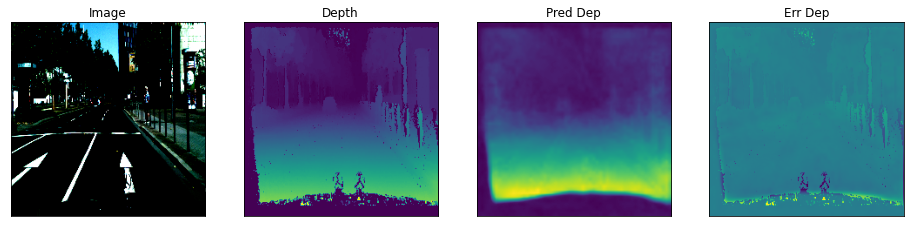

In [48]:
'''
visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Person_mask=mask.data.numpy().transpose(1,2,0)[..., 1],
    depth = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0),
    pred_mask = output['seg'].transpose(1,2,0)[..., 0],
    dep_mask = np.stack(output['dep']*3,axis=0),
)
'''
visualize(
    image=image.data.numpy().transpose(1,2,0), 
    depth = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0),
    Pred_dep = np.stack(output['dep']*3,axis=0),
    err_dep = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0) - np.stack(output['dep']*3,axis=0),
)

In [51]:
# Lets look at augmented data we have
dataset = CityDataset(x_valid_dir, y_valid_seg_dir,y_valid_dep_dir, classes=CLASSES,transform=None,preprocessing = get_preprocessing_fn())

ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']


model.eval()
output = dict()

with torch.no_grad():
    output['seg'],output['dep']= model(image[None,:,:,:].cuda())
    #output['seg'],output['dep']= model(image[None,:,:,:])
    output['seg'] = get_output(output['seg'],'seg')

output['seg'] = (output['seg'].cpu().numpy().transpose(1,2,0).squeeze())
output['dep'] = (output['dep'].squeeze().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


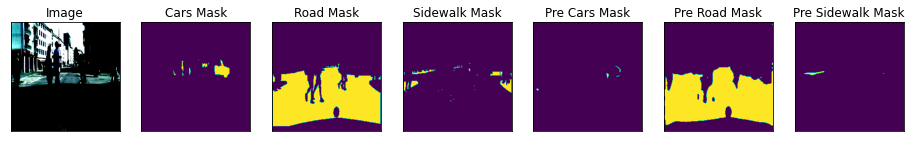

In [52]:

Pred_masks = []

for v in range(len(CLASSES)):
    if v == 19:
        Pred_masks.append(( output['seg'] == 255))
    else :
        Pred_masks.append((output['seg'] == v))

Pred_mask = np.stack(Pred_masks, axis=-1).astype('float')


visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('car')],
    road_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('road')],
    sidewalk_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('sidewalk')],    
    Pre_cars_mask=Pred_mask[..., CLASSES.index('car')],
    Pre_road_mask=Pred_mask[..., CLASSES.index('road')],
    Pre_sidewalk_mask=Pred_mask[..., CLASSES.index('sidewalk')],
)

In [ ]:
loss_logger = torch.load(checkpoint)['loss_logger']
plt.plot(loss_logger)

In [ ]:
Metrics_train_logger = torch.load(checkpoint,map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))['Metrics_train_logger']

mIoU_train = []
rmse_train = []
log_rmse_train = []

for i in range(len(Metrics_train_logger)):
    mIoU_train.append(Metrics_train_logger[i]['seg']['mIoU'])
    rmse_train.append(Metrics_train_logger[i]['dep']['rmse'])
    log_rmse_train.append(Metrics_train_logger[i]['dep']['log_rmse']) 

In [ ]:
plt.plot(mIoU_train)

In [ ]:
plt.plot(rmse_train)

In [ ]:
plt.plot(log_rmse_train)

In [ ]:
Metrics_val_logger = torch.load(checkpoint,map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))['Metrics_val_logger']

mIoU_val = []
rmse_val = []
log_rmse_val = []

for i in range(len(Metrics_val_logger)):
    mIoU_val.append(Metrics_val_logger[i]['mIoU'])
    rmse_val.append(Metrics_val_logger[i]['rmse'])
    log_rmse_val.append(Metrics_val_logger[i]['log_rmse'])

In [ ]:
plt.plot(mIoU_val)

In [ ]:
plt.plot(rmse_val)

In [ ]:
plt.plot(log_rmse_val)

In [ ]:
plt.plot(mIoU_train[14:],label='Train')
plt.plot(mIoU_val,label ='val')
plt.legend(loc="upper left")
plt.title("Plot of mIou")
plt.xlabel("epoch-number")
plt.ylabel("mIou")

In [ ]:
plt.plot(log_rmse_train[14:],label='Train')
plt.plot(log_rmse_val,label ='val')
plt.legend(loc="upper left")
plt.title("Plot of log-rmse")
plt.xlabel("epoch-number")
plt.ylabel("log-rmse")